# PursuitEvasion16x16-v0 Heuristic experiment analysis 

In [1]:
import copy
import os.path as osp

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import posggym_agents

import baposgmcp.plot as plot_utils
import baposgmcp.plot.paper as paper_utils
from baposgmcp.config import BASE_REPO_DIR

baposgmcp_results_file = osp.join(
    BASE_REPO_DIR, "experiments", "PursuitEvasion16x16-v0", "results", "experiment_results.csv"
)
figure_dir = osp.join(
    BASE_REPO_DIR, "experiments", "PursuitEvasion16x16-v0", "figures"
)
policy_results_file = osp.join(
    posggym_agents.config.BASE_DIR, 'agents', "pursuitevasion16x16_v0", "results", "pairwise_results.csv"
)

## Define Co-Player Prior

In [2]:
# Uniform
# Note K4 is not in prior 
policy_prior = {
    0: {
        "klr_k0_seed0_i0-v0": 1/4,
        "klr_k1_seed0_i0-v0": 1/4,
        "klr_k2_seed0_i0-v0": 1/4,
        "klr_k3_seed0_i0-v0": 1/4
    },
    1: {
        "klr_k0_seed0_i1-v0": 1/4,
        "klr_k1_seed0_i1-v0": 1/4,
        "klr_k2_seed0_i1-v0": 1/4,
        "klr_k3_seed0_i1-v0": 1/4
    }
}
coplayer_policy_ids = list(policy_prior[0]) + list(policy_prior[1])
coplayer_policy_ids.sort()
fixed_policy_ids = coplayer_policy_ids + ["klr_k4_seed0_i0-v0", "klr_k4_seed0_i1-v0"]
fixed_policy_ids.sort()

# Problem size

- Grid size = 16 x 16
- Num free coods = 145 
- Num goal = 3

**States**

```
= evader_states * pursuer_states 
= (pos * dir * goal * min_goal_dist) * (pos * dir)
= (145 * 4 * 3 * 23) * (145 * 4) 
= 23,211,600
```

**Actions** = 4 (Forward, Backward, Left, Right)

**Observations**

```
= adj_cells * seed * heard * evader_start_coord, pursuer_start_coord * goal_coord
= 2**4 * 2 * 2 * 6 * 2 * 6
= 4,608
```

Coord observations are constant throught an episode so only influence branching for the initial observation.
Given agents know their initial location and the map is fixed and known the branching is `2*2=4`.

## The Environment

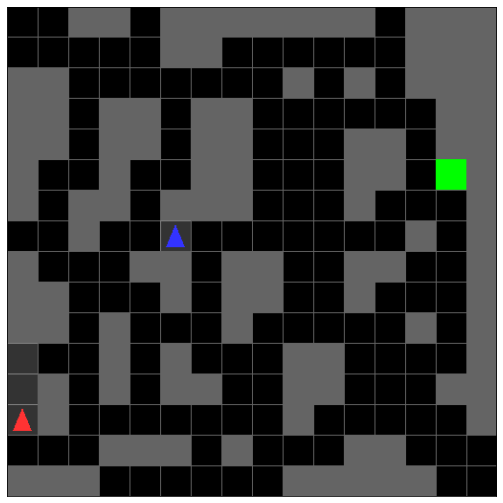

In [3]:
fig, ax = plot_utils.plot_environment("PursuitEvasion16x16-v0", (9, 9))
fig.savefig(osp.join(figure_dir, "env.png"))
plt.show()

## Loading Fixed Policy Data

In [4]:
policy_df = plot_utils.import_results(
    policy_results_file, clean_policy_id=True, add_coplayer_policy_id=True
)

all_fixed_policy_ids = policy_df["policy_id"].unique().tolist()
all_fixed_policy_ids.sort()
print("All Fixed Policies")
print("------------------")
for pi_id in all_fixed_policy_ids:
    print("  ", pi_id)
    
    
# Drop unneeded co-player policies
policy_df = policy_df[policy_df["policy_id"].isin(fixed_policy_ids)]
fixed_policy_ids = policy_df["policy_id"].unique().tolist()
fixed_policy_ids.sort()
print("\nExperiment Fixed Policies")
print("-------------------------")
for pi_id in fixed_policy_ids:
    print("  ", pi_id)

print("\nColumns")
print("-------")
for c in policy_df.columns:
    print("  ", c)

All Fixed Policies
------------------
   klr_k0_seed0_i0-v0
   klr_k0_seed0_i1-v0
   klr_k0_seed1_i0-v0
   klr_k0_seed1_i1-v0
   klr_k0_seed2_i0-v0
   klr_k0_seed2_i1-v0
   klr_k0_seed3_i0-v0
   klr_k0_seed3_i1-v0
   klr_k0_seed4_i0-v0
   klr_k0_seed4_i1-v0
   klr_k1_seed0_i0-v0
   klr_k1_seed0_i1-v0
   klr_k1_seed1_i0-v0
   klr_k1_seed1_i1-v0
   klr_k1_seed2_i0-v0
   klr_k1_seed2_i1-v0
   klr_k1_seed3_i0-v0
   klr_k1_seed3_i1-v0
   klr_k1_seed4_i0-v0
   klr_k1_seed4_i1-v0
   klr_k2_seed0_i0-v0
   klr_k2_seed0_i1-v0
   klr_k2_seed1_i0-v0
   klr_k2_seed1_i1-v0
   klr_k2_seed2_i0-v0
   klr_k2_seed2_i1-v0
   klr_k2_seed3_i0-v0
   klr_k2_seed3_i1-v0
   klr_k2_seed4_i0-v0
   klr_k2_seed4_i1-v0
   klr_k3_seed0_i0-v0
   klr_k3_seed0_i1-v0
   klr_k3_seed1_i0-v0
   klr_k3_seed1_i1-v0
   klr_k3_seed2_i0-v0
   klr_k3_seed2_i1-v0
   klr_k3_seed3_i0-v0
   klr_k3_seed3_i1-v0
   klr_k3_seed4_i0-v0
   klr_k3_seed4_i1-v0
   klr_k4_seed0_i0-v0
   klr_k4_seed0_i1-v0
   klr_k4_seed1_i0-v0
   klr_k4_seed1_

## Fixed policies pairwise performance

This is what was used to generate the meta-policies.

In [5]:
fixed_policies_0 = [
    "klr_k0_seed0_i0-v0",
    "klr_k1_seed0_i0-v0",
    "klr_k2_seed0_i0-v0",
    "klr_k3_seed0_i0-v0",
    "klr_k4_seed0_i0-v0"
]
fixed_policies_1 = [
    "klr_k0_seed0_i1-v0",
    "klr_k1_seed0_i1-v0",
    "klr_k2_seed0_i1-v0",
    "klr_k3_seed0_i1-v0",
    "klr_k4_seed0_i1-v0"
]
fixed_policy_labels={
    "klr_k0_seed0_i0-v0": "K0_0",
    "klr_k1_seed0_i0-v0": "K1_0",
    "klr_k2_seed0_i0-v0": "K2_0",
    "klr_k3_seed0_i0-v0": "K3_0",
    "klr_k4_seed0_i0-v0": "K4_0",
    "klr_k0_seed0_i1-v0": "K0_1",
    "klr_k1_seed0_i1-v0": "K1_1",
    "klr_k2_seed0_i1-v0": "K2_1",
    "klr_k3_seed0_i1-v0": "K3_1",
    "klr_k4_seed0_i1-v0": "K4_1",
}

/home/jonathon/code/ba-posgmcp/baposgmcp/plot/pairwise.py:39: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  pw_values[row_policy_idx][col_policy_idx] = group.mean()[y_key]
/home/jonathon/code/ba-posgmcp/baposgmcp/plot/pairwise.py:39: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  pw_values[row_policy_idx][col_policy_idx] = group.mean()[y_key]
/home/jonathon/code/ba-posgmcp/baposgmcp/plot/pairwise.py:39: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  pw_values[row_policy_idx][col_policy_i

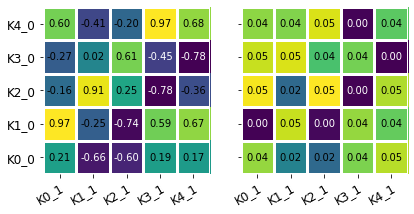

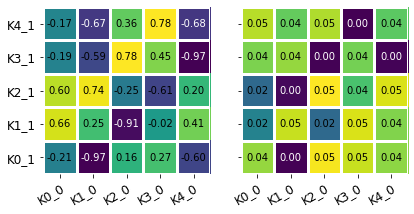

In [6]:
fig, axs = plot_utils.plot_pairwise_comparison(
    policy_df,
    y_key="episode_return_mean", 
    policy_key="policy_id",
    y_err_key="episode_return_CI",
    vrange=None, 
    figsize=(6, 3), 
    valfmt="{x:.2f}",
    policies=fixed_policies_0,
    coplayer_policies=fixed_policies_1,
    policy_labels=fixed_policy_labels,
    average_duplicates=True,
    duplicate_warning=False
)
fig.savefig(osp.join(figure_dir, "fixed_policy_payoff_0.png"))

fig, axs = plot_utils.plot_pairwise_comparison(
    policy_df,
    y_key="episode_return_mean", 
    policy_key="policy_id",
    y_err_key="episode_return_CI",
    vrange=None, 
    figsize=(6, 3), 
    valfmt="{x:.2f}",
    policies=fixed_policies_1,
    coplayer_policies=fixed_policies_0,
    policy_labels=fixed_policy_labels,
    average_duplicates=True,
    duplicate_warning=False
)
fig.savefig(osp.join(figure_dir, "fixed_policy_payoff_1.png"))

In [7]:
# Get payofss in meta policy dictionary format (for use in experiments)
pw_values, (row_policies, col_policies) = plot_utils.get_pairwise_values(
    policy_df,
    y_key="episode_return_mean", 
    policy_key="policy_id",
    policies=fixed_policies_0,
    coplayer_policies=fixed_policies_1,
    average_duplicates=True,
    duplicate_warning=True
)

for c, col_policy in enumerate(col_policies):
    print(f'(-1, "{col_policy}"):', "{")
    for r, row_policy in enumerate(row_policies):
        print(f'    "{row_policy}": {pw_values[r][c]:.2f},')
    print("},")
    
pw_values, (row_policies, col_policies) = plot_utils.get_pairwise_values(
    policy_df,
    y_key="episode_return_mean", 
    policy_key="policy_id",
    policies=fixed_policies_1,
    coplayer_policies=fixed_policies_0,
    average_duplicates=True,
    duplicate_warning=True
)


for c, col_policy in enumerate(col_policies):
    print(f'("{col_policy}", -1):', "{")
    for r, row_policy in enumerate(row_policies):
        print(f'    "{row_policy}": {pw_values[r][c]:.2f},')
    print("},")

/home/jonathon/code/ba-posgmcp/baposgmcp/plot/pairwise.py:39: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  pw_values[row_policy_idx][col_policy_idx] = group.mean()[y_key]
/home/jonathon/code/ba-posgmcp/baposgmcp/plot/pairwise.py:39: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  pw_values[row_policy_idx][col_policy_idx] = group.mean()[y_key]


(-1, "klr_k0_seed0_i1-v0"): {
    "klr_k0_seed0_i0-v0": 0.21,
    "klr_k1_seed0_i0-v0": 0.97,
    "klr_k2_seed0_i0-v0": -0.16,
    "klr_k3_seed0_i0-v0": -0.27,
    "klr_k4_seed0_i0-v0": 0.60,
},
(-1, "klr_k1_seed0_i1-v0"): {
    "klr_k0_seed0_i0-v0": -0.66,
    "klr_k1_seed0_i0-v0": -0.25,
    "klr_k2_seed0_i0-v0": 0.91,
    "klr_k3_seed0_i0-v0": 0.02,
    "klr_k4_seed0_i0-v0": -0.41,
},
(-1, "klr_k2_seed0_i1-v0"): {
    "klr_k0_seed0_i0-v0": -0.60,
    "klr_k1_seed0_i0-v0": -0.74,
    "klr_k2_seed0_i0-v0": 0.25,
    "klr_k3_seed0_i0-v0": 0.61,
    "klr_k4_seed0_i0-v0": -0.20,
},
(-1, "klr_k3_seed0_i1-v0"): {
    "klr_k0_seed0_i0-v0": 0.19,
    "klr_k1_seed0_i0-v0": 0.59,
    "klr_k2_seed0_i0-v0": -0.78,
    "klr_k3_seed0_i0-v0": -0.45,
    "klr_k4_seed0_i0-v0": 0.97,
},
(-1, "klr_k4_seed0_i1-v0"): {
    "klr_k0_seed0_i0-v0": 0.17,
    "klr_k1_seed0_i0-v0": 0.67,
    "klr_k2_seed0_i0-v0": -0.36,
    "klr_k3_seed0_i0-v0": -0.78,
    "klr_k4_seed0_i0-v0": 0.68,
},
("klr_k0_seed0_i0-v0", 

### Add Full-Knowledge Best-Response baseline

In [8]:
# Maps policy_id -> best response policy_id
best_response_map = {
    0: {
        "klr_k0_seed0_i1-v0": "klr_k1_seed0_i0-v0",
        "klr_k1_seed0_i1-v0": "klr_k2_seed0_i0-v0",
        "klr_k2_seed0_i1-v0": "klr_k3_seed0_i0-v0",
        "klr_k3_seed0_i1-v0": "klr_k4_seed0_i0-v0",
        # "klr_k4_seed0_i1-v0": "klr_k4_seed0_i0-v0",
    }, 
    1: {
        "klr_k0_seed0_i0-v0": "klr_k1_seed0_i1-v0",
        "klr_k1_seed0_i0-v0": "klr_k2_seed0_i1-v0",
        "klr_k2_seed0_i0-v0": "klr_k3_seed0_i1-v0",
        "klr_k3_seed0_i0-v0": "klr_k4_seed0_i1-v0",
        # "klr_k4_seed0_i0-v0": "klr_k4_seed0_i1-v0",
    }
}

new_rows = []
for (agent_id, coplayer_agent_id) in [(0, 1), (1, 0)]:
    for coplayer_policy_id, br_policy_id in best_response_map[agent_id].items():
        next_exp_id = policy_df["exp_id"].max() + 1
        br_row = policy_df.loc[
            (policy_df["agent_id"] == agent_id)
            & (policy_df["policy_id"] == br_policy_id) 
            & (policy_df["coplayer_policy_id"] == coplayer_policy_id)
        ].copy()
        br_coplayer_row = policy_df.loc[
            (policy_df["agent_id"] == coplayer_agent_id)
            & (policy_df["exp_id"].isin(br_row["exp_id"]))
        ].copy()
        # update policy id to baseline name
        br_row["policy_id"] = f"full-knowledge-br_i{agent_id}"
        # update exp ids to avoid duplicates
        br_row["exp_id"] = next_exp_id
        br_coplayer_row["exp_id"] = next_exp_id
        new_rows.append(br_row)
        new_rows.append(br_coplayer_row)

print(len(new_rows))
br_df = pd.concat(new_rows, axis='rows').reset_index(drop=True)
print(len(br_df))
policy_br_df = pd.concat([policy_df, br_df], ignore_index=True)

print(len(policy_br_df))
policy_br_df[policy_br_df["policy_id"].isin(["full-knowledge-br_i0", "full-knowledge-br_i1"])]

16
16
386


,exp_id,agent_id,env_id,policy_id,exp_seed,num_episodes,time_limit,episode_return_mean,episode_return_std,episode_return_max,...,episode_return_CI,episode_steps_CI,episode_time_CI,prop_LOSS,prop_DRAW,prop_WIN,prop_NA,num_sims,truncated,coplayer_policy_id
370,1339,0,PursuitEvasion16x16-v0,full-knowledge-br_i0,0,1000,None,0.965419,0.018966,0.991935,...,0.001176,0.272501,0.001036,0.000,0.0,1.000,0.000,0,False,klr_k0_seed0_i1-v0
372,1339,0,PursuitEvasion16x16-v0,full-knowledge-br_i0,0,1000,None,0.911089,0.296733,0.991935,...,0.018392,0.374425,0.001199,0.032,0.0,0.968,0.000,0,False,klr_k1_seed0_i1-v0
374,1339,0,PursuitEvasion16x16-v0,full-knowledge-br_i0,0,1000,None,0.608452,0.607099,0.991935,...,0.037628,1.728013,0.005550,0.122,0.0,0.714,0.164,0,False,klr_k2_seed0_i1-v0
376,1339,0,PursuitEvasion16x16-v0,full-knowledge-br_i0,0,1000,None,0.965653,0.019036,0.991935,...,0.001180,0.274766,0.001033,0.000,0.0,1.000,0.000,0,False,klr_k3_seed0_i1-v0
378,1339,1,PursuitEvasion16x16-v0,full-knowledge-br_i1,0,1000,None,0.663605,0.382248,0.798387,...,0.023692,0.257832,0.000837,0.053,0.0,0.947,0.000,0,False,klr_k0_seed0_i0-v0
380,1339,1,PursuitEvasion16x16-v0,full-knowledge-br_i1,0,1000,None,0.740653,0.028971,0.790323,...,0.001796,0.205305,0.000668,0.000,0.0,1.000,0.000,0,False,klr_k1_seed0_i0-v0
382,1339,1,PursuitEvasion16x16-v0,full-knowledge-br_i1,0,1000,None,0.779145,0.017689,0.806452,...,0.001096,0.180085,0.000591,0.000,0.0,1.000,0.000,0,False,klr_k2_seed0_i0-v0
384,1339,1,PursuitEvasion16x16-v0,full-knowledge-br_i1,0,1000,None,0.777556,0.012517,0.806452,...,0.000776,0.253001,0.000852,0.000,0.0,1.000,0.000,0,False,klr_k3_seed0_i0-v0


## Loading BAPOSGMCP Data

In [9]:
baposgmcp_df = plot_utils.import_results(
    baposgmcp_results_file, clean_policy_id=True, add_coplayer_policy_id=True
)
policy_ids = baposgmcp_df["policy_id"].unique().tolist()
policy_ids.sort()
print("Policies")
print("--------")
for pi_id in policy_ids:
    print("  ", pi_id)

print("\nColumns")
print("-------")
for c in baposgmcp_df.columns:
    print("  ", c)

Policies
--------
   baposgmcp-fixed_i0_piklrk0seed0i0-v0_numsims2_truncatedTrue
   baposgmcp-fixed_i0_piklrk0seed0i0-v0_numsims5_truncatedTrue
   baposgmcp-fixed_i0_piklrk1seed0i0-v0_numsims2_truncatedTrue
   baposgmcp-fixed_i0_piklrk1seed0i0-v0_numsims5_truncatedTrue
   baposgmcp-fixed_i0_piklrk2seed0i0-v0_numsims2_truncatedTrue
   baposgmcp-fixed_i0_piklrk2seed0i0-v0_numsims5_truncatedTrue
   baposgmcp-fixed_i0_piklrk3seed0i0-v0_numsims2_truncatedTrue
   baposgmcp-fixed_i0_piklrk3seed0i0-v0_numsims5_truncatedTrue
   baposgmcp-fixed_i0_piklrk4seed0i0-v0_numsims2_truncatedTrue
   baposgmcp-fixed_i0_piklrk4seed0i0-v0_numsims5_truncatedTrue
   baposgmcp-fixed_i1_piklrk0seed0i1-v0_numsims2_truncatedTrue
   baposgmcp-fixed_i1_piklrk0seed0i1-v0_numsims5_truncatedTrue
   baposgmcp-fixed_i1_piklrk1seed0i1-v0_numsims2_truncatedTrue
   baposgmcp-fixed_i1_piklrk1seed0i1-v0_numsims5_truncatedTrue
   baposgmcp-fixed_i1_piklrk2seed0i1-v0_numsims2_truncatedTrue
   baposgmcp-fixed_i1_piklrk2seed0i1-

## Combine data

In [10]:
# First need to update exp_ids of one dataframe so there are no duplicate exp_ids
df1 = baposgmcp_df
df2 = policy_br_df

df1_max_exp_id = df1["exp_id"].max()
if df2["exp_id"].min() <= df1_max_exp_id:
    df2["exp_id"] += df1_max_exp_id+1

combined_df = pd.concat([df1, df2]).reset_index(drop = True)


def add_alg_id(row):
    pi_id = row["policy_id"]
    if pi_id.startswith("klr"):
        return "fixed"
    tokens = pi_id.split("_")
    alg_id = "_".join([
        t for t in tokens 
        if all(
            s not in t for s in [
                "actionselection", "numsims", "truncated", "greedy", "softmax", "uniform", "piklr", "i0", "i1"
            ]
        )
    ])
    return alg_id


def add_meta_pi(row):
    pi_id = row["policy_id"]
    for meta_pi in ["greedy", "softmax", "uniform"]:
        if meta_pi in pi_id:
            return meta_pi
    return "NA"


combined_df["alg_id"] = combined_df.apply(add_alg_id, axis=1)
combined_df["meta_pi"] = combined_df.apply(add_meta_pi, axis=1)

policy_ids = combined_df["policy_id"].unique().tolist()
policy_ids.sort()
print("Policies")
print("--------")
for pi_id in policy_ids:
    print("  ", pi_id)
    
alg_ids = combined_df["alg_id"].unique().tolist()
alg_ids.sort()
print("\nAlg IDs")
print("-------")
for n in alg_ids:
    print("  ", n)
    
print("\nMeta Pis:")
print("---------")
print(combined_df["meta_pi"].unique().tolist())

print("\nColumns")
print("-------")
for c in baposgmcp_df.columns:
    print("  ", c)

Policies
--------
   baposgmcp-fixed_i0_piklrk0seed0i0-v0_numsims2_truncatedTrue
   baposgmcp-fixed_i0_piklrk0seed0i0-v0_numsims5_truncatedTrue
   baposgmcp-fixed_i0_piklrk1seed0i0-v0_numsims2_truncatedTrue
   baposgmcp-fixed_i0_piklrk1seed0i0-v0_numsims5_truncatedTrue
   baposgmcp-fixed_i0_piklrk2seed0i0-v0_numsims2_truncatedTrue
   baposgmcp-fixed_i0_piklrk2seed0i0-v0_numsims5_truncatedTrue
   baposgmcp-fixed_i0_piklrk3seed0i0-v0_numsims2_truncatedTrue
   baposgmcp-fixed_i0_piklrk3seed0i0-v0_numsims5_truncatedTrue
   baposgmcp-fixed_i0_piklrk4seed0i0-v0_numsims2_truncatedTrue
   baposgmcp-fixed_i0_piklrk4seed0i0-v0_numsims5_truncatedTrue
   baposgmcp-fixed_i1_piklrk0seed0i1-v0_numsims2_truncatedTrue
   baposgmcp-fixed_i1_piklrk0seed0i1-v0_numsims5_truncatedTrue
   baposgmcp-fixed_i1_piklrk1seed0i1-v0_numsims2_truncatedTrue
   baposgmcp-fixed_i1_piklrk1seed0i1-v0_numsims5_truncatedTrue
   baposgmcp-fixed_i1_piklrk2seed0i1-v0_numsims2_truncatedTrue
   baposgmcp-fixed_i1_piklrk2seed0i1-

## Pairwise performance

Here we look at the performance of each policy against each other policy including BAPOSGMCP and baselines with different number of simulations, action selection, and meta-policies.

/home/jonathon/code/ba-posgmcp/baposgmcp/plot/pairwise.py:39: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  pw_values[row_policy_idx][col_policy_idx] = group.mean()[y_key]
/home/jonathon/code/ba-posgmcp/baposgmcp/plot/pairwise.py:39: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  pw_values[row_policy_idx][col_policy_idx] = group.mean()[y_key]


(<Figure size 1728x2232 with 2 Axes>,
 array([[<AxesSubplot:>, <AxesSubplot:>]], dtype=object))

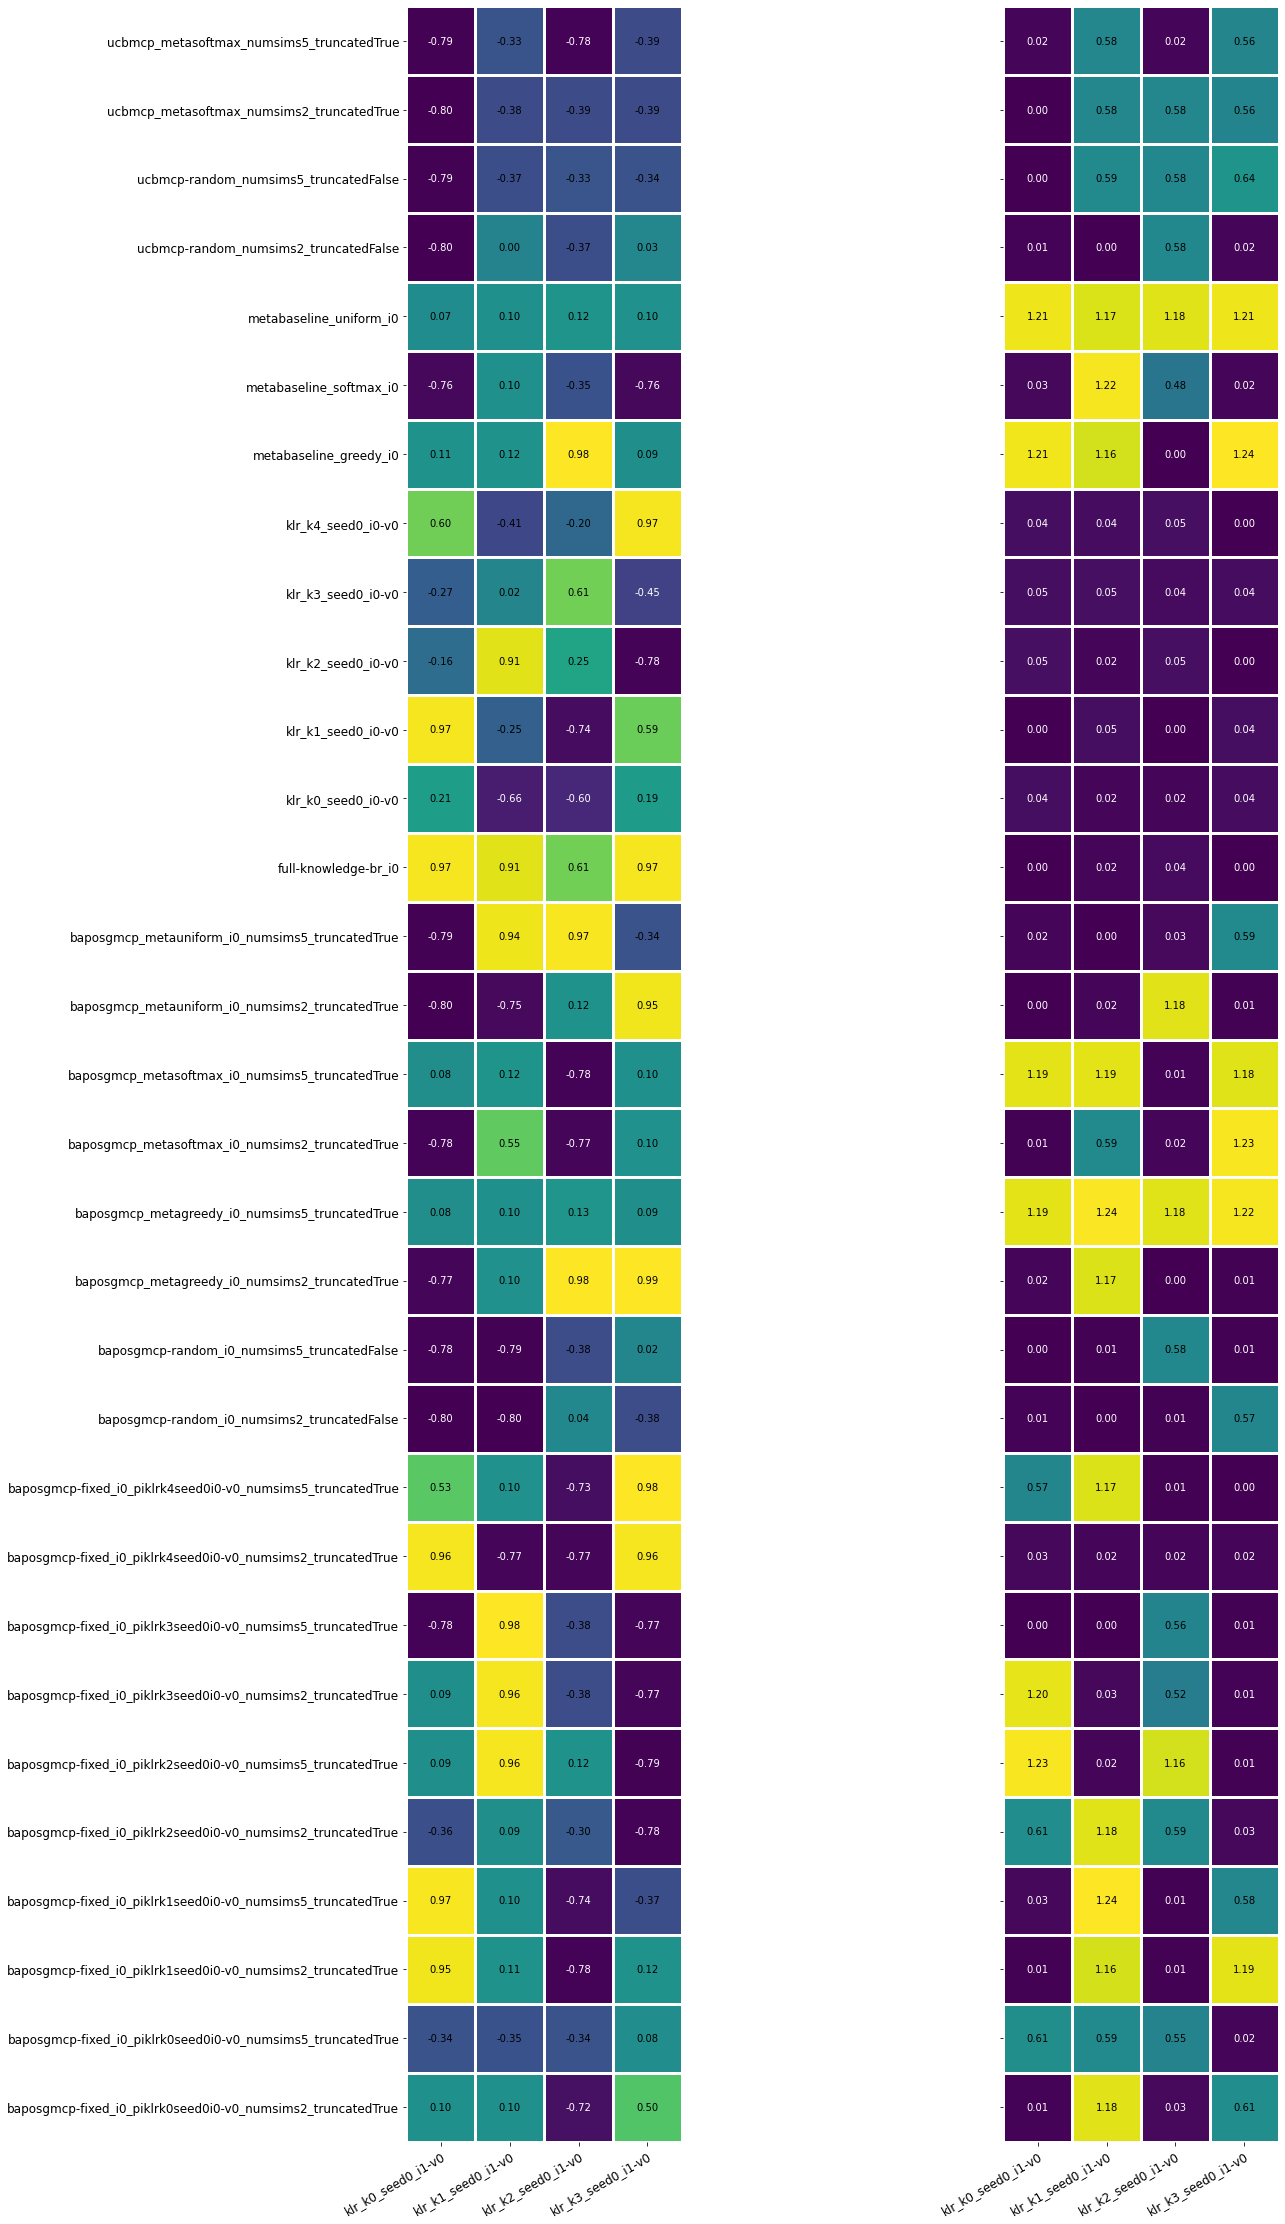

In [11]:
agent_0_df = combined_df[combined_df["agent_id"] == 0]
plot_utils.plot_pairwise_comparison(
    agent_0_df,
    y_key="episode_return_mean", 
    policy_key="policy_id",
    y_err_key="episode_return_CI",
    vrange=None, 
    figsize=(24, len(agent_0_df["policy_id"].unique())), 
    valfmt="{x:.2f}",
    coplayer_policies=list(policy_prior[1]),
    average_duplicates=True,
    duplicate_warning=False
)

/home/jonathon/code/ba-posgmcp/baposgmcp/plot/pairwise.py:39: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  pw_values[row_policy_idx][col_policy_idx] = group.mean()[y_key]
/home/jonathon/code/ba-posgmcp/baposgmcp/plot/pairwise.py:39: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  pw_values[row_policy_idx][col_policy_idx] = group.mean()[y_key]


(<Figure size 1728x2232 with 2 Axes>,
 array([[<AxesSubplot:>, <AxesSubplot:>]], dtype=object))

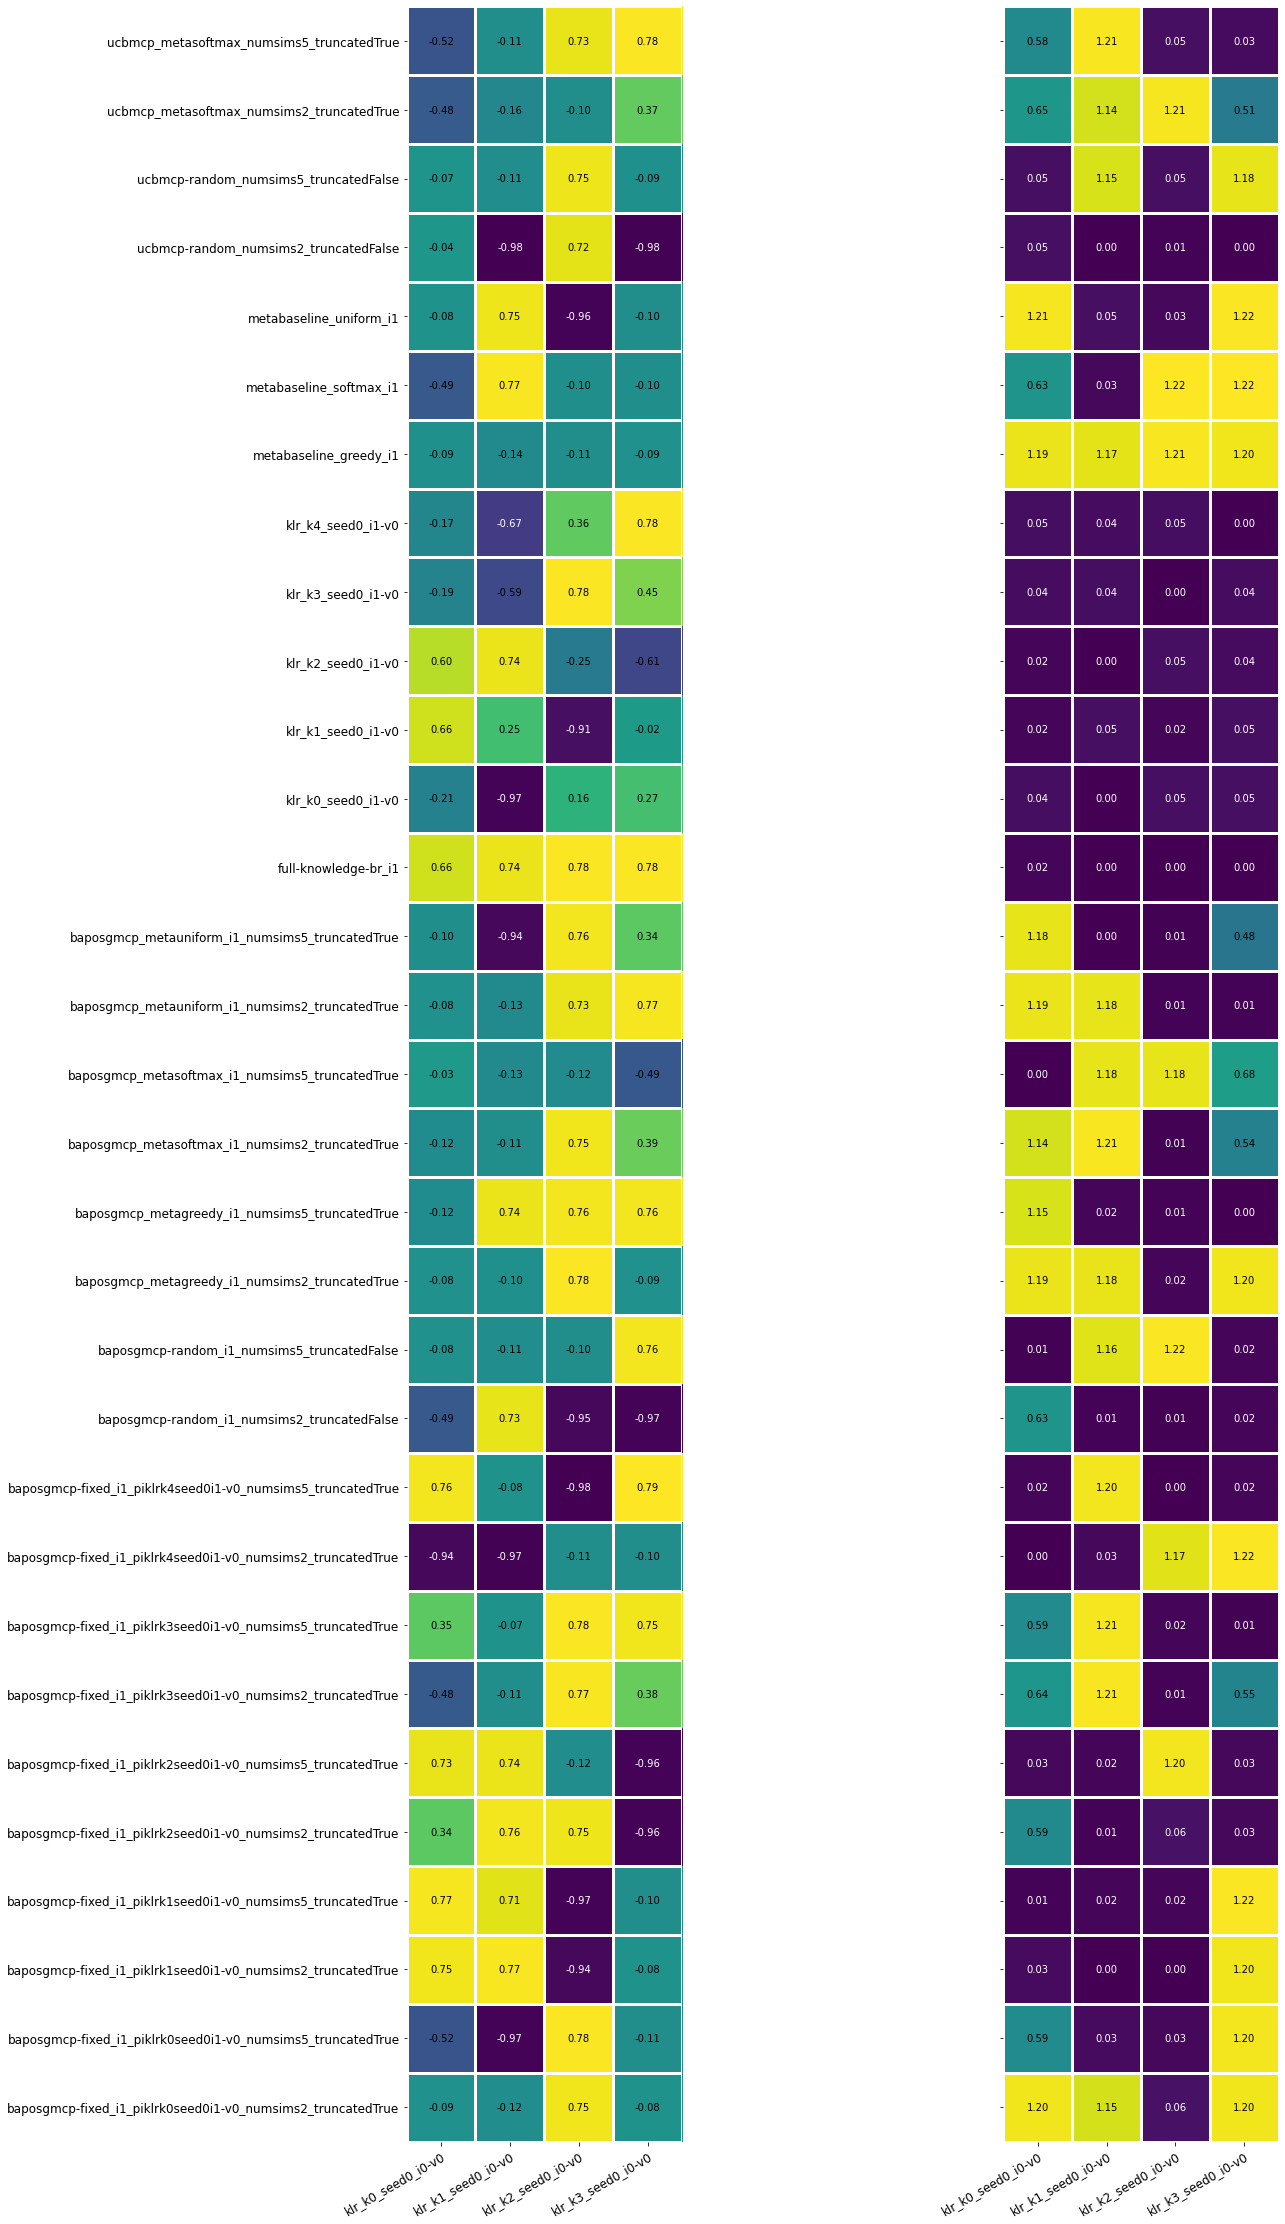

In [12]:
agent_1_df = combined_df[combined_df["agent_id"] == 1]
plot_utils.plot_pairwise_comparison(
    agent_1_df,
    y_key="episode_return_mean", 
    policy_key="policy_id",
    y_err_key="episode_return_CI",
    vrange=None, 
    figsize=(24, len(agent_1_df["policy_id"].unique())), 
    valfmt="{x:.2f}",
    coplayer_policies=list(policy_prior[0]),
    average_duplicates=True,
    duplicate_warning=False
)

/home/jonathon/code/ba-posgmcp/baposgmcp/plot/pairwise.py:39: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  pw_values[row_policy_idx][col_policy_idx] = group.mean()[y_key]


(<Figure size 1728x2232 with 1 Axes>, array([[<AxesSubplot:>]], dtype=object))

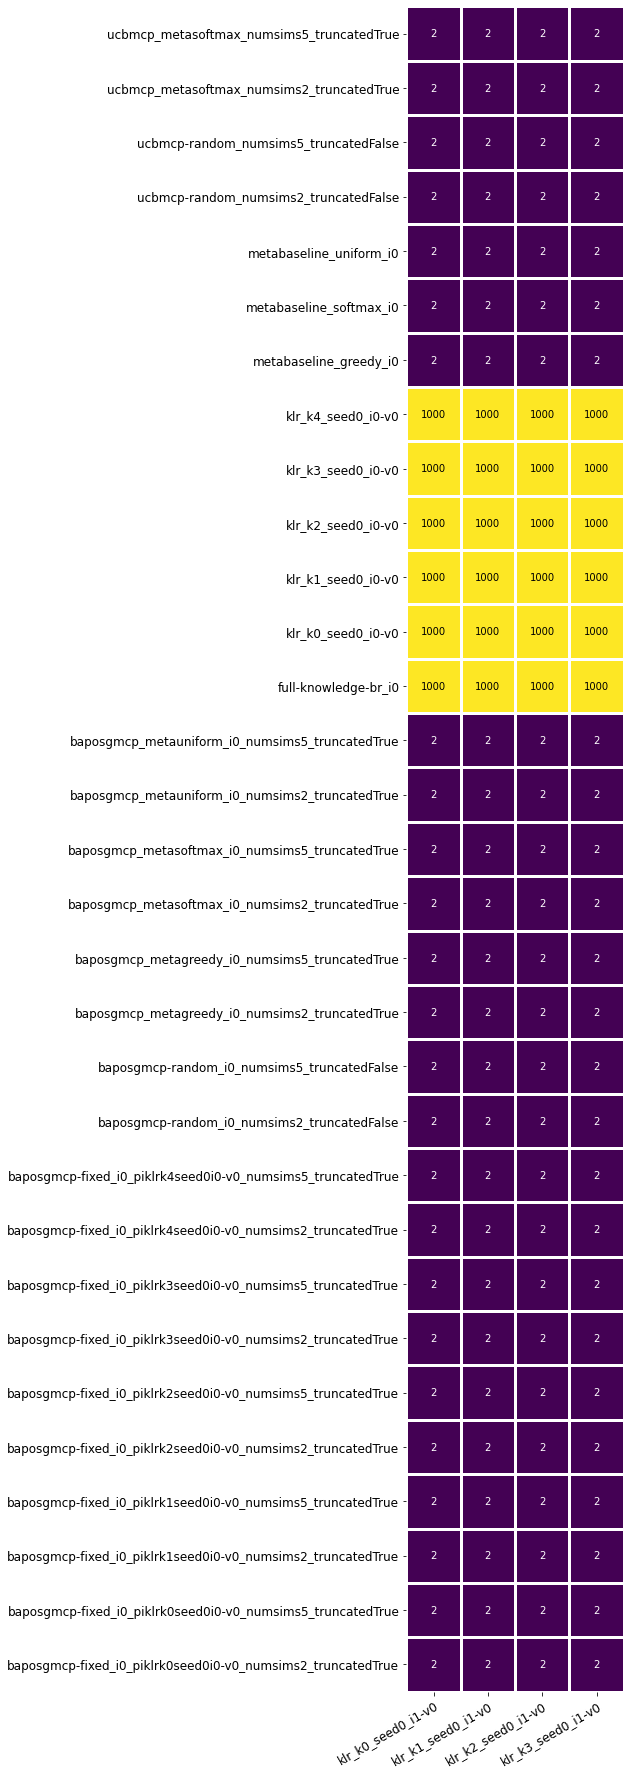

In [13]:
plot_utils.plot_pairwise_comparison(
    agent_0_df,
    y_key="num_episodes", 
    policy_key="policy_id",
    y_err_key=None,
    vrange=None, 
    figsize=(24, len(agent_0_df["policy_id"].unique())),  
    valfmt="{x:.0f}",
    coplayer_policies=list(policy_prior[1]),
    average_duplicates=True,
    duplicate_warning=False
)

/home/jonathon/code/ba-posgmcp/baposgmcp/plot/pairwise.py:39: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  pw_values[row_policy_idx][col_policy_idx] = group.mean()[y_key]


(<Figure size 1728x2232 with 1 Axes>, array([[<AxesSubplot:>]], dtype=object))

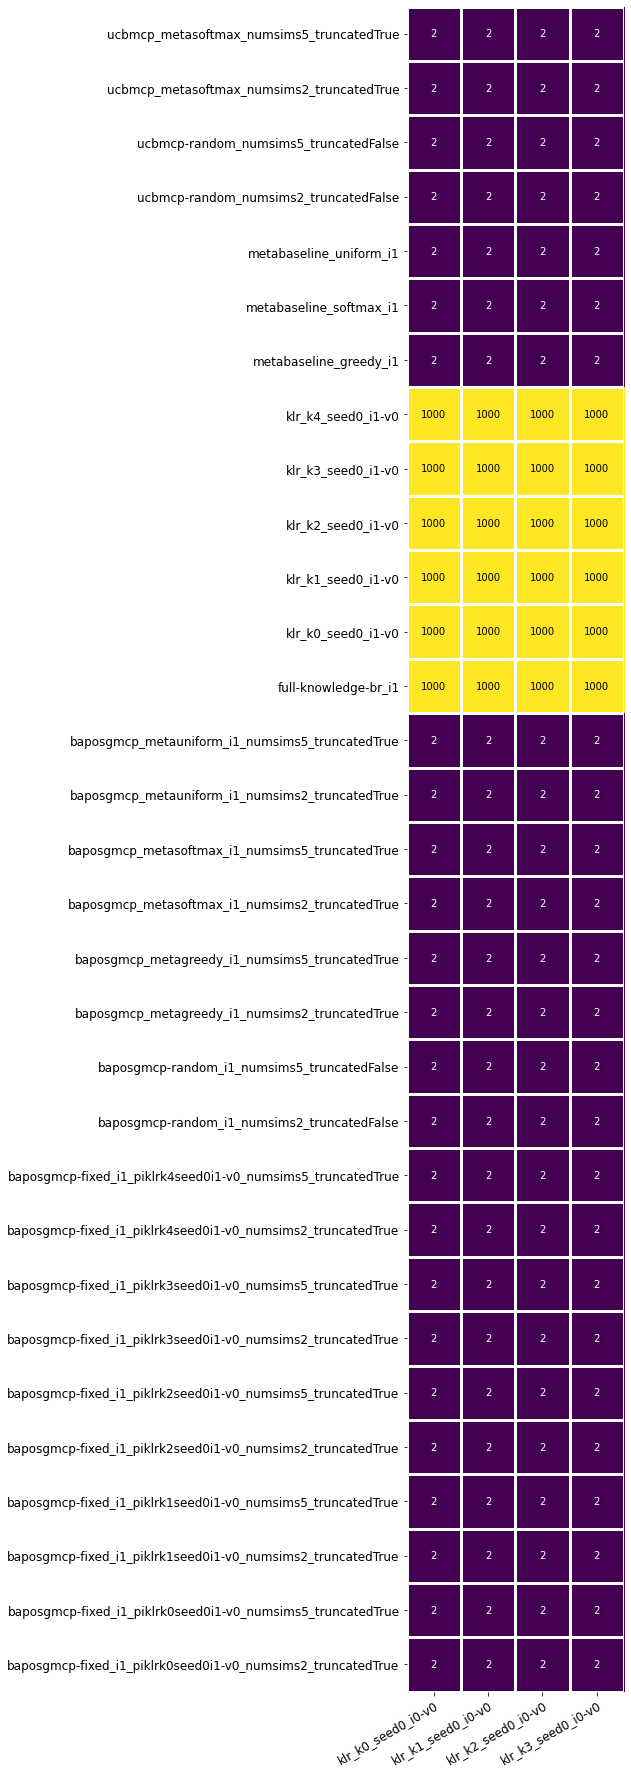

In [14]:
plot_utils.plot_pairwise_comparison(
    agent_1_df,
    y_key="num_episodes", 
    policy_key="policy_id",
    y_err_key=None,
    vrange=None, 
    figsize=(24, len(agent_1_df["policy_id"].unique())),  
    valfmt="{x:.0f}",
    coplayer_policies=list(policy_prior[0]),
    average_duplicates=True,
    duplicate_warning=False
)

# Expected Performance

Here we look at the expected performance given the policy prior of BAPOSGMCP and the different baselines.

Specifically:

1. Comparing different meta-policies
2. Comparing performance using meta-policy vs using a single fixed policy
3. Comparing performance between all algorithms

In [15]:
exp_df = plot_utils.get_uniform_expected_df(
    combined_df, 
    coplayer_policies=coplayer_policy_ids,
    coplayer_policy_key="coplayer_policy_id"
)

Ungrouped size = 254
Grouped size = 58


In [16]:
# Base plot kwargs
base_plot_kwargs = paper_utils.get_base_plot_kwargs()
return_plot_kwargs = copy.deepcopy(base_plot_kwargs)
return_plot_kwargs["subplot_kwargs"].update({
    "ylabel": "Mean Episode Return",
})

step_plot_kwargs = copy.deepcopy(return_plot_kwargs)
step_plot_kwargs["subplot_kwargs"].update({
    "ylabel": "Mean Episode Steps"
})

## Comparison of the different Meta-Policies

Here we look at the performance of our algorithm using the difference meta-policies.

Looking at performance with:

- truncated search
- using PUCB

We also look at the performance of the metabaseline with the different meta-policies.

In [17]:
meta_pi_label_map = {
    "greedy": r"$\sigma^{G}$",
    "softmax": r"$\sigma^{S}$",
    "uniform": r"$\sigma^{U}$",
}

meta_pi_df = exp_df[
    (exp_df["action_selection"].isin(["pucb", None]))
    & (
        (exp_df["alg_id"].isin(["metabaseline"]))
        | (
            (exp_df["alg_id"].isin(["baposgmcp"])) & (exp_df["truncated"] == True)
        )
    )
]

meta_alg_ids = meta_pi_df["alg_id"].unique().tolist()
meta_alg_ids.sort()
print("Alg IDs")
print("-------")
for n in meta_alg_ids:
    print(n)
    
policy_ids = meta_pi_df["policy_id"].unique().tolist()
policy_ids.sort()
print("\nPolicy IDs")
print("----------")
for n in policy_ids:
    print(n)

Alg IDs
-------
baposgmcp
metabaseline

Policy IDs
----------
baposgmcp_metagreedy_i0_numsims2_truncatedTrue
baposgmcp_metagreedy_i0_numsims5_truncatedTrue
baposgmcp_metagreedy_i1_numsims2_truncatedTrue
baposgmcp_metagreedy_i1_numsims5_truncatedTrue
baposgmcp_metasoftmax_i0_numsims2_truncatedTrue
baposgmcp_metasoftmax_i0_numsims5_truncatedTrue
baposgmcp_metasoftmax_i1_numsims2_truncatedTrue
baposgmcp_metasoftmax_i1_numsims5_truncatedTrue
baposgmcp_metauniform_i0_numsims2_truncatedTrue
baposgmcp_metauniform_i0_numsims5_truncatedTrue
baposgmcp_metauniform_i1_numsims2_truncatedTrue
baposgmcp_metauniform_i1_numsims5_truncatedTrue
metabaseline_greedy_i0
metabaseline_greedy_i1
metabaseline_softmax_i0
metabaseline_softmax_i1
metabaseline_uniform_i0
metabaseline_uniform_i1


agent_id=0
alg_id='baposgmcp'
alg_id='metabaseline'
agent_id=1
alg_id='baposgmcp'
alg_id='metabaseline'


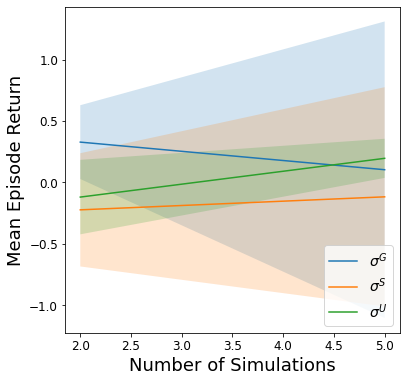

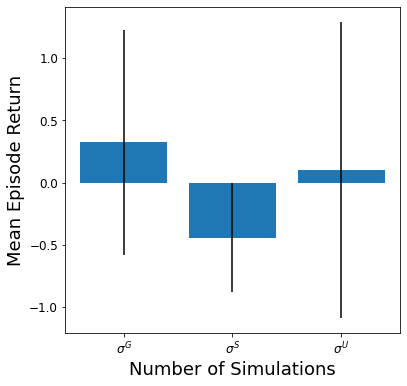

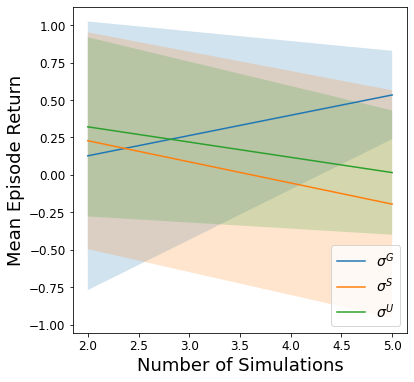

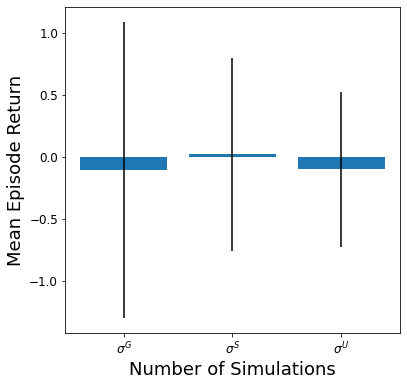

In [18]:
plot_kwargs = copy.deepcopy(return_plot_kwargs)
plot_kwargs["subplot_kwargs"].update({
    # "ylim": (-1.0, 1.0),
})
plot_kwargs["legend_kwargs"].update({
    "loc": "lower right",
    # "title": "Meta-Policy" 
})

for agent_id in [0, 1]:
    print(f"{agent_id=}")
    for alg_id in meta_alg_ids:
        print(f"{alg_id=}")
        fig, _ = plot_utils.paper.plot_multiple_meta_policy_vs_num_sims(
            meta_pi_df[(meta_pi_df["agent_id"] == agent_id) & (meta_pi_df["alg_id"] == alg_id)],
            y_key="episode_return_mean",
            y_err_key="episode_return_CI",
            meta_pi_label_map=meta_pi_label_map,
            alg_id_key="alg_id",
            set_title=False,
            **plot_kwargs
        )
        fig.savefig(osp.join(figure_dir, f"meta_pi_return_{alg_id}_i{agent_id}.png"))
    
del plot_kwargs

## Comparing Meta-Policy versus no meta-policy (using a single policy)

Here we look at the performance of BAPOSGMCP with a meta-policy against not using a meta-policy (i.e. using the different fixed policies).

Parameters:

- Truncated search (except for random)
- using PUCB

In [19]:
# TODO May need to change BAPOSGMCP meta policy depending on results
# BAPOSGMCP Meta-Policy
# 0: Best = uniform (but only marginally at lower #sims (i.e. 100))
#           Performance is roughly equal between all meta Pis at higher sims >=500
# 1: Best = clearly softmax > greedy > uniform
#
# Hence I use softmax for remainder of analysis

meta_vs_no_pi_label_map = {
    0: {
        # "baposgmcp_uniform": r"$\sigma^{U}$",
        "baposgmcp_metasoftmax": r"$\sigma^{S}$",
        "baposgmcp-random_i0": "Random",
        "baposgmcp-fixed_i0_piklrk0seed0i0-v0": "K0_0",
        "baposgmcp-fixed_i0_piklrk1seed0i0-v0": "K1_0",
        "baposgmcp-fixed_i0_piklrk2seed0i0-v0": "K2_0",
        "baposgmcp-fixed_i0_piklrk3seed0i0-v0": "K3_0",
    },
    1: {
        # "baposgmcp_uniform": r"$\sigma^{U}$",
        "baposgmcp_metasoftmax": r"$\sigma^{S}$",
        "baposgmcp-random_i1": "Random",
        "baposgmcp-fixed_i1_piklrk0seed0i1-v0": "K0_1",
        "baposgmcp-fixed_i1_piklrk1seed0i1-v0": "K1_1",
        "baposgmcp-fixed_i1_piklrk2seed0i1-v0": "K2_1",
        "baposgmcp-fixed_i1_piklrk3seed0i1-v0": "K3_1",
    }
}

# Use DF containing only policies with PUCB action_selection or NA
meta_vs_no_meta_df = exp_df[
    (exp_df["alg_id"].isin(["baposgmcp", "baposgmcp-fixed", "baposgmcp-random"]))
    & (exp_df["action_selection"].isin(["pucb"]))
    & (exp_df["meta_pi"].isin(["softmax", "NA"]))
    & (
        ((exp_df["alg_id"] == "baposgmcp-random") & (exp_df["truncated"] == False))
        | ((exp_df["alg_id"].isin(["baposgmcp", "baposgmcp-fixed"])) & (exp_df["truncated"] == True))
    )
]

meta_vs_no_meta_alg_ids = meta_vs_no_meta_df["alg_id"].unique().tolist()
meta_vs_no_meta_alg_ids.sort()
print("Alg IDs")
print("-------")
for n in meta_vs_no_meta_alg_ids:
    print(n)
    
policy_ids = meta_vs_no_meta_df["policy_id"].unique().tolist()
policy_ids.sort()
print("\nPolicy IDs")
print("----------")
for n in policy_ids:
    print(n)
    
fixed_policy_ids = meta_vs_no_meta_df["fixed_policy_id"].unique().tolist()
print("\nFixed Policy IDs")
print("----------------")
for n in fixed_policy_ids:
    print(n)

Alg IDs
-------
baposgmcp
baposgmcp-fixed
baposgmcp-random

Policy IDs
----------
baposgmcp-fixed_i0_piklrk0seed0i0-v0_numsims2_truncatedTrue
baposgmcp-fixed_i0_piklrk0seed0i0-v0_numsims5_truncatedTrue
baposgmcp-fixed_i0_piklrk1seed0i0-v0_numsims2_truncatedTrue
baposgmcp-fixed_i0_piklrk1seed0i0-v0_numsims5_truncatedTrue
baposgmcp-fixed_i0_piklrk2seed0i0-v0_numsims2_truncatedTrue
baposgmcp-fixed_i0_piklrk2seed0i0-v0_numsims5_truncatedTrue
baposgmcp-fixed_i0_piklrk3seed0i0-v0_numsims2_truncatedTrue
baposgmcp-fixed_i0_piklrk3seed0i0-v0_numsims5_truncatedTrue
baposgmcp-fixed_i0_piklrk4seed0i0-v0_numsims2_truncatedTrue
baposgmcp-fixed_i0_piklrk4seed0i0-v0_numsims5_truncatedTrue
baposgmcp-fixed_i1_piklrk0seed0i1-v0_numsims2_truncatedTrue
baposgmcp-fixed_i1_piklrk0seed0i1-v0_numsims5_truncatedTrue
baposgmcp-fixed_i1_piklrk1seed0i1-v0_numsims2_truncatedTrue
baposgmcp-fixed_i1_piklrk1seed0i1-v0_numsims5_truncatedTrue
baposgmcp-fixed_i1_piklrk2seed0i1-v0_numsims2_truncatedTrue
baposgmcp-fixed_i1

agent_id=0
agent_id=1


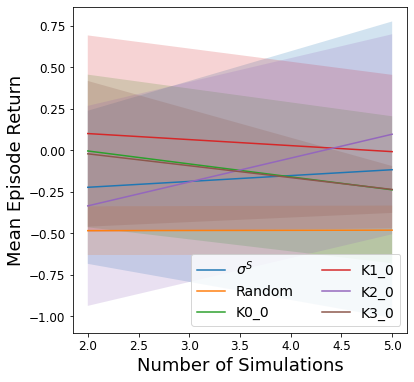

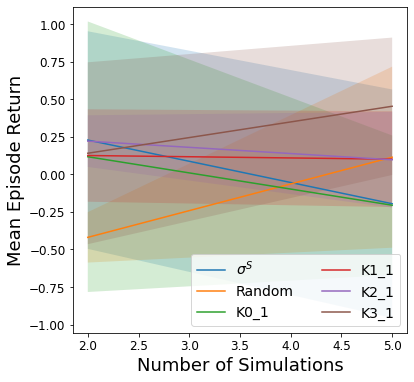

In [20]:
plot_kwargs = copy.deepcopy(return_plot_kwargs)
plot_kwargs["subplot_kwargs"].update({
    # "ylim": (-0.5, 1.0),
})
plot_kwargs["legend_kwargs"].update({
    "loc": "lower right",
    # "title": "Policy",
    "ncol": 2
})

for agent_id in [0, 1]:
    print(f"{agent_id=}")
    fig, _ = plot_utils.paper.plot_multiple_performance_vs_num_sims(
        meta_vs_no_meta_df[meta_vs_no_meta_df["agent_id"] == agent_id],
        y_key="episode_return_mean",
        y_err_key="episode_return_CI",
        policy_prefixes=[list(meta_vs_no_pi_label_map[agent_id])],
        pi_label_map=meta_vs_no_pi_label_map[agent_id],
        **plot_kwargs,
    )

    fig.savefig(osp.join(figure_dir, f"meta_vs_fixed_return_i{agent_id}.png"))
    
del plot_kwargs

agent_id=0
agent_id=1


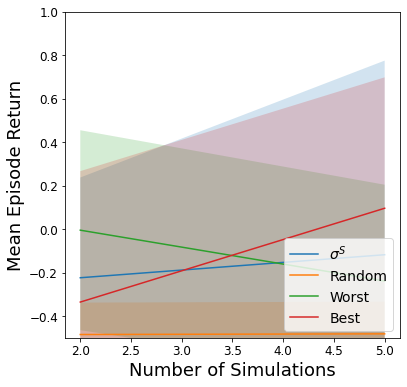

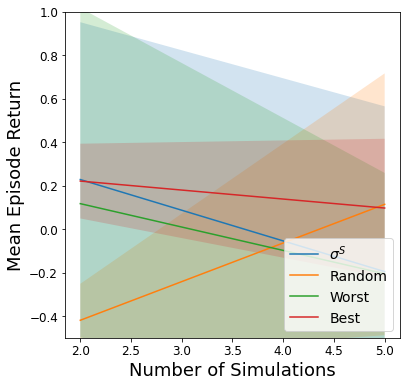

In [21]:
meta_vs_no_best_and_worst_pi_label_map = {
    0: {
        # "baposgmcp_uniform": r"$\sigma^{U}$",
        "baposgmcp_metasoftmax": r"$\sigma^{S}$",
        "baposgmcp-random_i0": "Random",
        "baposgmcp-fixed_i0_piklrk0seed0i0-v0": "Worst",
        #"baposgmcp-fixed_i0_piklrk1seed0i0-v0": "K1_0",
        "baposgmcp-fixed_i0_piklrk2seed0i0-v0": "Best",
        # "baposgmcp-fixed_i0_piklrk3seed0i0-v0": "K3_0",
    },
    1: {
        # "baposgmcp_uniform": r"$\sigma^{U}$",
        "baposgmcp_metasoftmax": r"$\sigma^{S}$",
        "baposgmcp-random_i1": "Random",
        "baposgmcp-fixed_i1_piklrk0seed0i1-v0": "Worst",
        # "baposgmcp-fixed_i1_piklrk1seed0i1-v0": "K1_1",
        "baposgmcp-fixed_i1_piklrk2seed0i1-v0": "Best",
        # "baposgmcp-fixed_i1_piklrk3seed0i1-v0": "K3_1",
    }
}

plot_kwargs = copy.deepcopy(return_plot_kwargs)
plot_kwargs["subplot_kwargs"].update({
    "ylim": (-0.5, 1.0),
})
plot_kwargs["legend_kwargs"].update({
    "loc": "lower right",
    # "title": "Policy" 
})

for agent_id in [0, 1]:
    print(f"{agent_id=}")
    fig, _ = plot_utils.paper.plot_multiple_performance_vs_num_sims(
        meta_vs_no_meta_df[meta_vs_no_meta_df["agent_id"] == agent_id],
        y_key="episode_return_mean",
        y_err_key="episode_return_CI",
        policy_prefixes=[list(meta_vs_no_best_and_worst_pi_label_map[agent_id])],
        pi_label_map=meta_vs_no_best_and_worst_pi_label_map[agent_id],
        **plot_kwargs,
    )

    fig.savefig(osp.join(figure_dir, f"meta_vs_fixed_return_best_and_worst_i{agent_id}.png"))
    
del plot_kwargs

## Comparing BAPOSGMCP versus baselines

Finally we compare BAPOSGMCP versus baselines. Specifically we compare:

- BAPOSGMCP (PUCB + Best Meta)
- IPOMCP-Meta (UCB + Best Meta)
- IPOMCP (UCB + Random)
- Full Knowledge BR
- Meta

In [22]:
best_meta_pi = "softmax"
perf_df = exp_df[
    (exp_df["alg_id"] == "full-knowledge-br")
    | ((exp_df["alg_id"] == "metabaseline") & (exp_df["meta_pi"] == best_meta_pi))
    | ((exp_df["alg_id"] == "baposgmcp") & (exp_df["meta_pi"] == best_meta_pi) & (exp_df["truncated"] == True))
    | ((exp_df["alg_id"] == "ucbmcp") & (exp_df["meta_pi"] == best_meta_pi) & (exp_df["truncated"] == True))
    | ((exp_df["alg_id"] == "ucbmcp-random") & (exp_df["truncated"] == False))
]

policy_prefixes_to_plot = [
    f"baposgmcp_meta{best_meta_pi}",
    f"metabaseline_{best_meta_pi}",
    f"full-knowledge-br",
    "ucbmcp-random",
    f"ucbmcp_meta{best_meta_pi}"
]

baseline_pi_label_map = {
    f"baposgmcp_meta{best_meta_pi}": "BAPOSGMCP",
    "baposgmcp-random": "BAPOSGMCP Random", 
    "full-knowledge-br": "Best-Response",
    f"metabaseline_{best_meta_pi}": "Meta-Policy",
    f"ucbmcp_meta{best_meta_pi}": "UCB + Meta",
    "ucbmcp-random": "UCB + Random"
}

perf_ids = perf_df["alg_id"].unique().tolist()
perf_ids.sort()
print("Alg IDs")
print("-------")
for n in perf_ids:
    print(n)
    
policy_ids = perf_df["policy_id"].unique().tolist()
policy_ids.sort()
print("\nPolicy IDs")
print("----------")
for n in policy_ids:
    print(n)

Alg IDs
-------
baposgmcp
full-knowledge-br
metabaseline
ucbmcp
ucbmcp-random

Policy IDs
----------
baposgmcp_metasoftmax_i0_numsims2_truncatedTrue
baposgmcp_metasoftmax_i0_numsims5_truncatedTrue
baposgmcp_metasoftmax_i1_numsims2_truncatedTrue
baposgmcp_metasoftmax_i1_numsims5_truncatedTrue
full-knowledge-br_i0
full-knowledge-br_i1
metabaseline_softmax_i0
metabaseline_softmax_i1
ucbmcp-random_numsims2_truncatedFalse
ucbmcp-random_numsims5_truncatedFalse
ucbmcp_metasoftmax_numsims2_truncatedTrue
ucbmcp_metasoftmax_numsims5_truncatedTrue


agent_id=0
agent_id=1


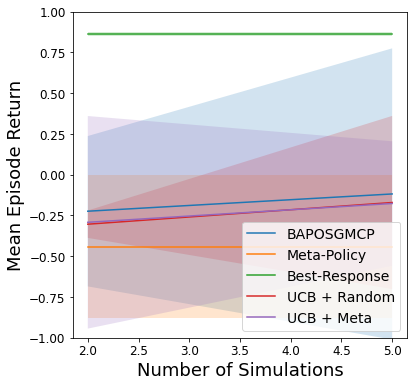

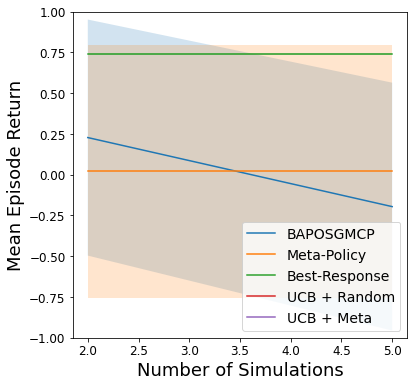

In [23]:
plot_kwargs = copy.deepcopy(return_plot_kwargs)
plot_kwargs["subplot_kwargs"].update({
    "ylim": (-1.0, 1.0),
})
plot_kwargs["legend_kwargs"].update({
    "loc": "lower right",
})

for agent_id in [0, 1]:
    print(f"{agent_id=}")
    fig, _ = plot_utils.paper.plot_multiple_performance_vs_num_sims(
        perf_df[perf_df["agent_id"] == agent_id],
        y_key="episode_return_mean",
        y_err_key="episode_return_CI",
        policy_prefixes=[policy_prefixes_to_plot],
        pi_label_map=baseline_pi_label_map,
        **plot_kwargs,
    )

    fig.savefig(osp.join(figure_dir, f"baselines_return_i{agent_id}.png"))
    
del plot_kwargs

# Analysis

Here we take a deeper dive into the characteristics of BA-POSGMCP. Specifically looking at:

1. Belief accuracy
2. Planning time

## Looking at Belief accuracy by steps

- action_dist_distance
- bayes_accuracy

In [24]:
belief_df = exp_df[
    (exp_df["alg_id"] == "baposgmcp") 
    & (exp_df["truncated"] == True)
    & (exp_df["action_selection"] == "pucb")
]


belief_alg_ids = belief_df["alg_id"].unique().tolist()
belief_alg_ids.sort()
print("Alg IDs")
print("-------")
for n in belief_alg_ids:
    print(n)

# group over meta-policy values
belief_group_keys = ["alg_id", "num_sims"]
belief_agg_dict = plot_utils.get_uniform_expected_agg_map(exp_df)
for k in belief_group_keys:
    if k in belief_agg_dict:
        belief_agg_dict.pop(k)
        
gb = belief_df.groupby(belief_group_keys)
gb_agg = gb.agg(**belief_agg_dict)
belief_gb_df = gb_agg.reset_index()

belief_gb_df.sort_values(by=["num_sims"], inplace=True)

print("Ungrouped size =", len(belief_df))
print("Grouped size =", len(belief_gb_df))
print(belief_gb_df)

Alg IDs
-------
baposgmcp
Ungrouped size = 12
Grouped size = 2
      alg_id  num_sims  exp_id  exp_seed  agent_id                  env_id  \
0  baposgmcp         2       0         0         0  PursuitEvasion16x16-v0   
1  baposgmcp         5       4         0         0  PursuitEvasion16x16-v0   

  time_limit  episode_step_limit extra_particles_prop  truncated  ...  \
0       None               100.0               0.0625       True  ...   
1       None               100.0               0.0625       True  ...   

  min_value_CI max_value_CI episode_return_CI episode_discounted_return_CI  \
0     0.335367     0.029945          0.547200                     0.473982   
1     0.290980     0.039277          0.621479                     0.532045   

  episode_steps_CI episode_time_CI prop_LOSS prop_DRAW  prop_WIN   prop_NA  
0        11.953640        0.205032  0.416667       0.0  0.541667  0.041667  
1        15.331843        0.578154  0.395833       0.0  0.500000  0.104167  

[2 rows x 1290 

In [25]:
belief_plot_kwargs = copy.deepcopy(base_plot_kwargs)
belief_plot_kwargs["subplot_kwargs"].update({
    "xlabel": "Step",
})
belief_plot_kwargs["legend_kwargs"].update({
    "loc": "upper left",
    # "title": "Num. Sims." 
})

alg_id='baposgmcp'
agent_id=0
agent_id=1


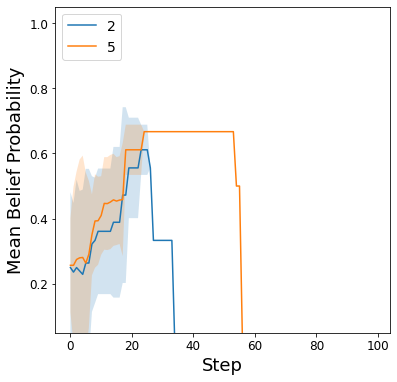

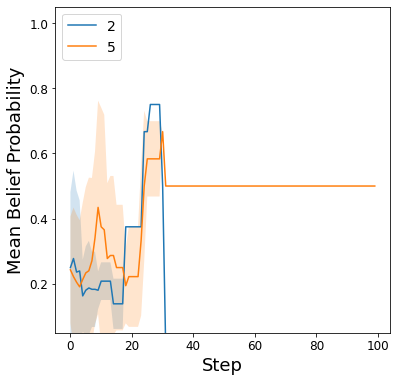

In [26]:
plot_kwargs = copy.deepcopy(belief_plot_kwargs)
plot_kwargs["subplot_kwargs"].update({
    "ylabel": "Mean Belief Probability",
    "ylim": (0.05, 1.05),
})
plot_kwargs["legend_kwargs"].update({
    "loc": "upper left",
})

for alg_id in belief_alg_ids:
    print(f"{alg_id=}")
    alg_df = belief_gb_df[belief_gb_df["alg_id"] == alg_id]
    for (i, j) in [(0, 1), (1, 0)]:
        print(f"agent_id={i}")
        fig, _ = plot_utils.paper.plot_multiple_belief_stats(
            alg_df,
            y_key_prefix="bayes_accuracy",
            step_limit=100,
            other_agent_id=j,
            y_suffix="mean",
            y_err_suffix="CI",
            alg_id_key="alg_id",
            **plot_kwargs
        )

        fig.savefig(osp.join(figure_dir, f"bayes_accuracy_{alg_id}_{i}.png"))
    
del plot_kwargs

alg_id='baposgmcp'
agent_id=0
agent_id=1


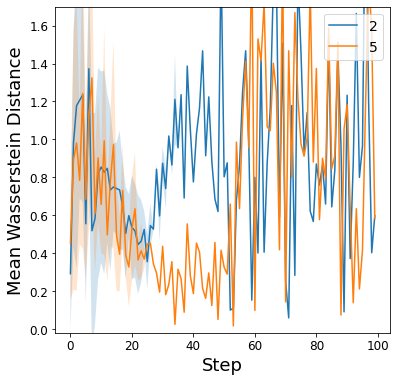

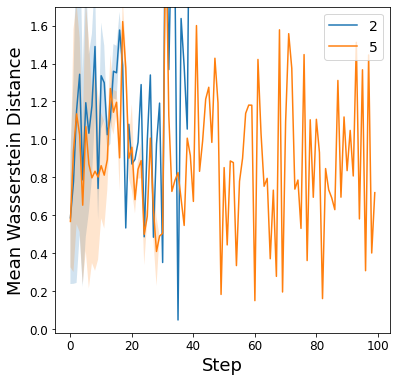

In [27]:
plot_kwargs = copy.deepcopy(belief_plot_kwargs)
plot_kwargs["subplot_kwargs"].update({
    "ylabel": "Mean Wasserstein Distance",
    "ylim": (-0.02, 1.7),
})

plot_kwargs["legend_kwargs"].update({
    "loc": "upper right",
})

for alg_id in belief_alg_ids:
    print(f"{alg_id=}")
    alg_df = belief_gb_df[belief_gb_df["alg_id"] == alg_id]
    for (i, j) in [(0, 1), (1, 0)]:
        print(f"agent_id={i}")
        fig, _ = plot_utils.paper.plot_multiple_belief_stats(
            alg_df,
            y_key_prefix="action_dist_distance",
            step_limit=100,
            other_agent_id=j,
            y_suffix="mean",
            y_err_suffix="CI",
            alg_id_key="alg_id",
            **plot_kwargs
        )

        fig.savefig(osp.join(figure_dir, f"action_dist_{alg_id}_{i}.png"))

    
del plot_kwargs

## Looking at time

   - search_time
   - update_time
   - reinvigoration_time
   - policy_calls
   - inference_time
   - search_depth

In [28]:
times_df = exp_df[
    (exp_df["action_selection"].isin(['pucb']))
    & (exp_df["alg_id"].isin(["baposgmcp"]))
    & (exp_df["meta_pi"] == "softmax")
]

print(times_df["truncated"].unique())

times_group_keys = ["alg_id", "truncated", "num_sims"]
times_agg_dict = plot_utils.get_uniform_expected_agg_map(exp_df)
for k in times_group_keys:
    if k in times_agg_dict:
        times_agg_dict.pop(k)
    
times_agg_dict["policy_id"] = pd.NamedAgg(column="policy_id", aggfunc="first")
        
gb = times_df.groupby(times_group_keys)
gb_agg = gb.agg(**times_agg_dict)
times_gb_df = gb_agg.reset_index()

times_gb_df.sort_values(by=["alg_id", "truncated", "num_sims"], inplace=True)

print("Ungrouped size =", len(times_df))
print("Grouped size =", len(times_gb_df))

times_alg_ids = times_gb_df["alg_id"].unique().tolist()
times_alg_ids.sort()
print("Alg IDs")
print("-------")
for n in times_alg_ids:
    print(n)
    
times_policy_ids = times_gb_df["policy_id"].unique().tolist()
times_policy_ids.sort()
print("\nPolicy IDs")
print("----------")
for n in times_policy_ids:
    print(n)
    
    
# based on output of policy IDs (since we group IDS)
time_pi_label_map = {
    "baposgmcp_metasoftmax": r"BAPOSGMCP",
}

sim_policies = [
    "baposgmcp_metasoftmax",
]

[ True]
Ungrouped size = 4
Grouped size = 2
Alg IDs
-------
baposgmcp

Policy IDs
----------
baposgmcp_metasoftmax_i0_numsims2_truncatedTrue
baposgmcp_metasoftmax_i0_numsims5_truncatedTrue


baposgmcp


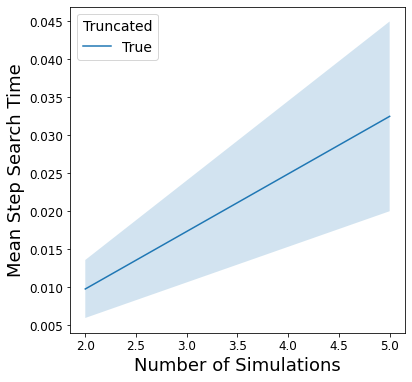

In [29]:
time_plot_kwargs = copy.deepcopy(return_plot_kwargs)
time_plot_kwargs["subplot_kwargs"].update({
    "ylabel": "Mean Step Search Time",
    # "ylim": (0, 75),
})
time_plot_kwargs["legend_kwargs"].update({
    "loc": 'upper left',
    "title": "Truncated",  
})

for alg_id in times_alg_ids:
    print(alg_id)
    fig, _ = paper_utils.plot_multiple_truncated_vs_num_sims_by_alg(
        times_gb_df[times_gb_df["alg_id"] == alg_id],
        y_key="search_time_mean",
        y_err_key="search_time_CI",
        alg_id_key="alg_id",
        set_title=False,
        **time_plot_kwargs
    )
    fig.savefig(osp.join(figure_dir, f"search_time_{alg_id}.png"))
    
del time_plot_kwargs

baposgmcp


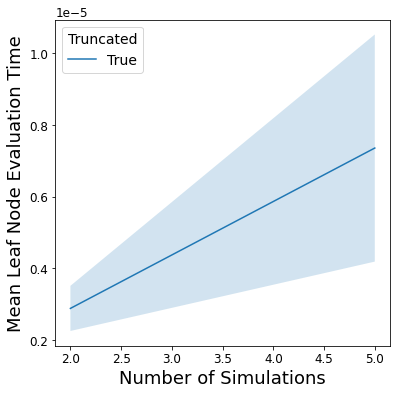

In [30]:
time_plot_kwargs = copy.deepcopy(return_plot_kwargs)
time_plot_kwargs["subplot_kwargs"].update({
    "ylabel": "Mean Leaf Node Evaluation Time",
    # "ylim": (0, 75),
})
time_plot_kwargs["legend_kwargs"].update({
    "loc": 'upper left',
    "title": "Truncated",  
})

for alg_id in times_alg_ids:
    print(alg_id)
    fig, _ = paper_utils.plot_multiple_truncated_vs_num_sims_by_alg(
        times_gb_df[times_gb_df["alg_id"] == alg_id],
        y_key="evaluation_time_mean",
        y_err_key="evaluation_time_CI",
        alg_id_key="alg_id",
        set_title=False,
        **time_plot_kwargs
    )
    fig.savefig(osp.join(figure_dir, f"eval_time_{alg_id}.png"))
    
del time_plot_kwargs

baposgmcp


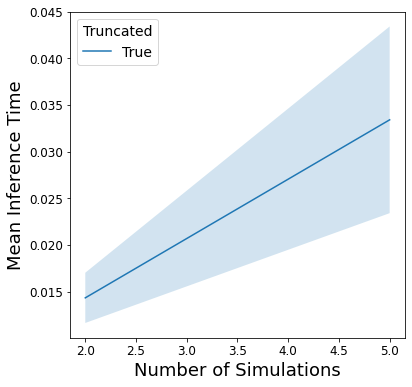

In [31]:
time_plot_kwargs = copy.deepcopy(return_plot_kwargs)
time_plot_kwargs["subplot_kwargs"].update({
    "ylabel": "Mean Inference Time",
    # "ylim": (0, 75),
})
time_plot_kwargs["legend_kwargs"].update({
    "loc": 'upper left',
    "title": "Truncated",  
})

for alg_id in times_alg_ids:
    print(alg_id)
    fig, _ = paper_utils.plot_multiple_truncated_vs_num_sims_by_alg(
        times_gb_df[times_gb_df["alg_id"] == alg_id],
        y_key="inference_time_mean",
        y_err_key="inference_time_CI",
        alg_id_key="alg_id",
        set_title=False,
        **time_plot_kwargs
    )
    fig.savefig(osp.join(figure_dir, f"inference_time_{alg_id}.png"))
    
del time_plot_kwargs

baposgmcp


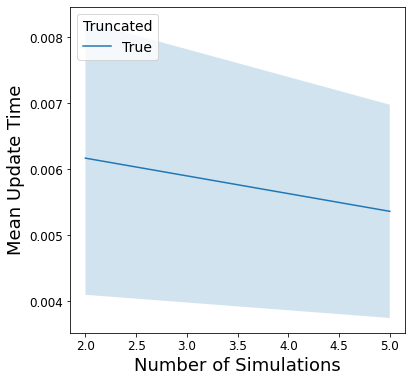

In [32]:
time_plot_kwargs = copy.deepcopy(return_plot_kwargs)
time_plot_kwargs["subplot_kwargs"].update({
    "ylabel": "Mean Update Time",
    # "ylim": (0, 75),
})
time_plot_kwargs["legend_kwargs"].update({
    "loc": 'upper left',
    "title": "Truncated",  
})

for alg_id in times_alg_ids:
    print(alg_id)
    fig, _ = paper_utils.plot_multiple_truncated_vs_num_sims_by_alg(
        times_gb_df[times_gb_df["alg_id"] == alg_id],
        y_key="update_time_mean",
        y_err_key="update_time_CI",
        alg_id_key="alg_id",
        set_title=False,
        **time_plot_kwargs
    )
    fig.savefig(osp.join(figure_dir, f"update_time_{alg_id}.png"))
    
del time_plot_kwargs

baposgmcp


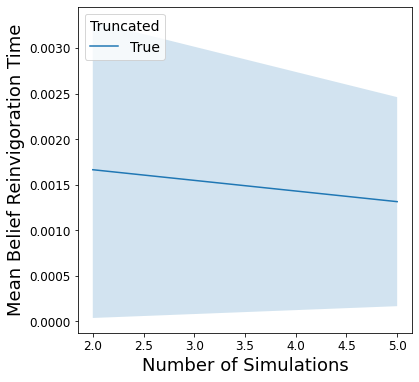

In [33]:
time_plot_kwargs = copy.deepcopy(return_plot_kwargs)
time_plot_kwargs["subplot_kwargs"].update({
    "ylabel": "Mean Belief Reinvigoration Time",
    # "ylim": (0, 75),
})
time_plot_kwargs["legend_kwargs"].update({
    "loc": 'upper left',
    "title": "Truncated",  
})

for alg_id in times_alg_ids:
    print(alg_id)
    fig, _ = paper_utils.plot_multiple_truncated_vs_num_sims_by_alg(
        times_gb_df[times_gb_df["alg_id"] == alg_id],
        y_key="reinvigoration_time_mean",
        y_err_key="reinvigoration_time_CI",
        alg_id_key="alg_id",
        set_title=False,
        **time_plot_kwargs
    )
    fig.savefig(osp.join(figure_dir, f"reinvigoration_time_{alg_id}.png"))
    
del time_plot_kwargs

baposgmcp


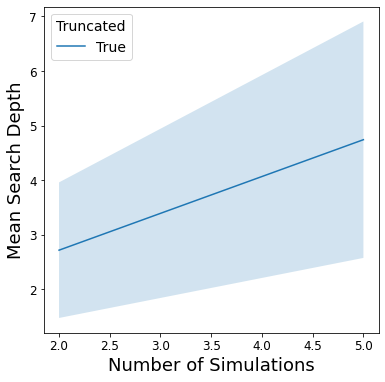

In [34]:
time_plot_kwargs = copy.deepcopy(return_plot_kwargs)
time_plot_kwargs["subplot_kwargs"].update({
    "ylabel": "Mean Search Depth",
    # "ylim": (0, 75),
})
time_plot_kwargs["legend_kwargs"].update({
    "loc": 'upper left',
    "title": "Truncated",  
})

for alg_id in times_alg_ids:
    print(alg_id)
    fig, _ = paper_utils.plot_multiple_truncated_vs_num_sims_by_alg(
        times_gb_df[times_gb_df["alg_id"] == alg_id],
        y_key="search_depth_mean",
        y_err_key="search_depth_CI",
        alg_id_key="alg_id",
        set_title=False,
        **time_plot_kwargs
    )
    fig.savefig(osp.join(figure_dir, f"search_depth_{alg_id}.png"))
    
del time_plot_kwargs